In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.odr import *

%matplotlib widget

In [2]:
import requests
from astropy.table import Table
from astropy.io import ascii
from astropy.coordinates import SkyCoord

def get_panstarrs_matches_unc(field_stars, radius):
    '''
    WIP

    radius in arcseconds
    '''
    radius = radius/3600.

    columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
        gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,
        gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr""".split(',')
    columns = [x.strip() for x in columns]
    columns = [x for x in columns if x and not x.startswith('#')]
    results = []
    constraints = {'nDetections.gt':1}
    for i in tqdm(range(len(field_stars))):
        results += [ps1cone(field_stars[i]['Ra'],field_stars[i]['Dec'],radius,release='dr2',columns=columns,**constraints)]
    out = clean_results(results)
    return out

def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)

def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = f"{baseurl}/{release}/{table}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text

def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = f"{baseurl}/{release}/{table}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab

def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))
    
def clean_results(results):
    out = []
    for i in range(len(results)):
        if len(results[i]) > 0:
            tab = ascii.read(results[i])
            # improve the format
            for filter in 'grizy':
                col = filter+'MeanPSFMag'
                try:
                    tab[col].format = ".4f"
                    tab[col][tab[col] == -999.0] = np.nan
                except KeyError:
                    print("{} not found".format(col))
        else:
            tab = []
        out += [tab]
    out_filtered = out
    for i in range(len(out)):
        inds = []
        if out[i] != []:
            outarr = out[i].to_pandas().to_numpy()
            for j in range(len(outarr)):
                if np.any(np.isnan(outarr[j])) == False:
                    inds += [j]
            out_filtered[i] = outarr[inds]
    return out_filtered

In [3]:
fields_init = np.load('../fields.npy') # Load the list of unique field stars in the dataset
field_obs_init = np.load('../field_obs.npy') # Load the list of field star observations

In [4]:
field_catalog_spec = np.dtype({'names': [
    'Matched', 'Nova name', 'Name', 'Ra', 'Dec',
    'Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
    'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr'
    ], 'formats': [
    bool,'U32', 'U32', float, float,
    float, float, float, float, float, float,
    float, float, float, float, float
    ]})

observation_catalog_spec = np.dtype({'names': [
    'Matched', 'Nova name', 'Name', 'Ra', 'Dec', 'Observation Time', 'Filter', 'Magnitude', 'Magnitude error',
    'Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
    'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr'
    ], 'formats': [
    bool,'U32','U32',float,float,float,'U1',float,float,
    float, float, float, float, float, float,
    float, float, float, float, float
    ]})

In [5]:
fields = np.empty(len(fields_init),dtype=field_catalog_spec)# Reformat the field list
for col in fields_init.dtype.names:
    fields[col] = fields_init[col] # Fill in the observation column, the remaining columns are for match (PanSTARRS) data
fields['Matched'] = False # Matched flag default to False until matches loaded

field_obs = np.empty(len(field_obs_init),dtype=observation_catalog_spec) # Reformat the field observation list
for col in field_obs_init.dtype.names:
    field_obs[col] = field_obs_init[col] # Fill in the observation column, the remaining columns are for match (PanSTARRS) data
field_obs['Matched'] = False # Matched flag default to False until matches loaded

In [6]:
fields_restricted = fields[fields['Dec'] > -30] # Cut data to match PanSTARRS area
field_obs_restricted = field_obs[field_obs['Dec'] > -30]

In [18]:
def format_matches(fields_restricted, matches_prelim):
    add_cols = ['Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr']
    add_col_inds = [0, 9, 10, 11, 12, 13,
        14, 15, 16, 17, 18]

    print('Processing unique star matches')
    for i in tqdm(range(len(fields_restricted))):
        if len(matches_prelim[i]) == 1: # If the match is 1-1 just set the relevant values
            for colname, ind in zip(add_cols, add_col_inds):
                fields_restricted[i][colname] = matches_prelim[i][0][ind]
            fields_restricted[i]['Matched'] = True
        elif len(matches_prelim[i]) > 1: # If there are multiple candidates choose the closest one
            observed = SkyCoord(ra = fields_restricted[i]['Ra'], dec = fields_restricted[i]['Dec'], unit='degree')
            separations = [np.inf]
            min_ind = 0
            for option_ind, option in enumerate(matches_prelim[i]): # Go through each option and compare separations
                opt = SkyCoord(ra = option[1], dec = option[2], unit='degree')
                sep = observed.separation(opt)
                if sep < min(separations):
                    min_ind = option_ind
                separations += [sep]
            choose = matches_prelim[i][min_ind] # Do the same assignment off the closest option
            for colname, ind in zip(add_cols, add_col_inds):
                fields_restricted[i][colname] = choose[ind]
            fields_restricted[i]['Matched'] = True
    return fields_restricted

def format_matches_obs(field_obs_restricted, fields_restricted):
    add_cols = ['Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr', 'Matched']

    print('Processing observation matches')
    for obs_ind in tqdm(range(len(field_obs_restricted))): # Add matched field columns to the field observation data
        name = field_obs_restricted[obs_ind]['Name']
        field_data = fields_restricted[fields_restricted['Name'] == name][0]
        for colname in add_cols:
            field_obs_restricted[obs_ind][colname] = field_data[colname]
    return field_obs_restricted

def check_data(field_obs_full):
    print('Checking data')
    dat = np.lib.recfunctions.append_fields(field_obs_full,['gGood','rGood','iGood','zGood','yGood'],[[False]*len(field_obs_full)]*5, dtypes=[bool]*5,usemask=False)[field_obs_full['Matched'] == True]
    for filter in 'grizy':
        for ind, row in enumerate(dat):
            if row[f'Pan {filter}MagErr'] >= 0 and row[f'Pan {filter}MagErr'] <= row[f'Pan {filter}Mag']:
                dat[ind][f'{filter}Good'] = True
    return dat

In [19]:
match_cache = Path("cache/pan_matches.npy")
if match_cache.is_file(): # Load match data if it already exists
    print('Loading cached matches.')
    matches_prelim = np.load('cache/pan_matches.npy', allow_pickle=True)
    fields_full = format_matches(fields_restricted, matches_prelim)
    field_obs_full = format_matches_obs(field_obs_restricted, fields_full)
    dat = check_data(field_obs_full) # Add masks for each filter
else: # Otherwise find new matches
    print('Requesting new matches')
    matches_prelim = get_panstarrs_matches_unc(fields_restricted, 2)
    fields_full = format_matches(fields_restricted, matches_prelim)
    field_obs_full = format_matches_obs(field_obs_restricted, fields_full)
    np.save('cache/pan_matches.npy',matches_prelim)
    dat = check_data(field_obs_full)

Loading cached matches.
Processing unique star matches


  0%|          | 0/3354 [00:00<?, ?it/s]

Processing observation matches


  0%|          | 0/489799 [00:00<?, ?it/s]

Checking data


In [20]:
times = np.unique(dat['Observation Time'])

In [21]:
def grubbs_test(y, ymask):
    ycurr = y[ymask]
    n = len(ycurr)
    a =  0.05
    p = a/(2*n)
    t = stats.t.ppf(1-p, n-2)

    G_crit = (n-1)/(np.sqrt(n))*np.sqrt(t**2/(n-2+t**2))
    G_ob = np.max(np.abs(ycurr - np.mean(ycurr)))/np.std(ycurr)
    if G_ob > G_crit:
        ymask[np.abs(y - np.mean(y)) >= np.max(np.abs(ycurr - np.mean(ycurr)))] = False
        ymask = grubbs_test(y, ymask)
    return ymask

def std2test(y, ymask):
    ycurr = y[ymask]
    thresh = 2*np.std(ycurr)

    if np.any(np.abs(ycurr - np.mean(ycurr)) > thresh):
        ymask[np.abs(y - np.mean(ycurr)) > thresh] = False
        std2test(y, ymask)
    return ymask

In [22]:
filter = 'g'
comp_filter = 'r'

In [24]:
def odr_lin(p,x):
    return p[0]*x+p[1]

def fit_color_term_errors(x,y,dx,dy):
    linear = Model(odr_lin)
    mydata = RealData(x, y, dx, dy)
    myodr = ODR(mydata, linear, beta0=[1, 1])
    myoutput = myodr.run()
    c = myoutput.beta[0]
    z = myoutput.beta[1]
    c_unc = myoutput.sd_beta[0]
    z_unc = myoutput.sd_beta[1]
    return c, z, c_unc, z_unc

In [26]:
filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]

color_terms = {'g': [], 'r': [], 'i': []}
color_term_errors = {'g': [], 'r': [], 'i': []}

# For each of the filters, perform a regression on the color term plot for each exposure, saves a list of color term estimates and uncertainties
for lis in filters:
    term = lis[2]
    print(f'finding C{term}')
    cs = []
    zs = []
    c_uncs = []
    z_uncs = []
    all_points = dat[np.logical_and.reduce((dat[f'{lis[0]}Good'] == True, dat[f'{lis[1]}Good'] == True, dat[f'{lis[3]}Good'] == True, dat['Filter'] == lis[2]))]
    times = np.unique(all_points['Observation Time'])
    total_observations = len(all_points)
    rejected_observations = 0
    for time in tqdm(times):
        points = all_points[all_points['Observation Time'] == time]
        x = points[f'Pan {lis[0]}Mag'] - points[f'Pan {lis[1]}Mag']
        y = points['Magnitude'] - points[f'Pan {lis[3]}Mag']
        xerr = np.sqrt(points[f'Pan {lis[0]}MagErr']**2 + points[f'Pan {lis[1]}MagErr']**2)
        yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {lis[3]}MagErr'])
        ymask = np.ones_like(y, dtype=bool)
        ymask_adj = std2test(y, ymask)
        xa = x[ymask_adj]
        ya = y[ymask_adj]
        xerra = xerr[ymask_adj]
        yerra = yerr[ymask_adj]
        c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
        cs += [c]
        zs += [z]
        c_uncs += [c_unc]
        z_uncs += [z_unc]
        rejected_observations += np.count_nonzero(np.logical_not(ymask_adj))
    color_terms[term] = cs
    color_term_errors[term] = c_uncs
    print(f'Rejected {rejected_observations} of {total_observations} observations ({rejected_observations/total_observations*100:.2f}%)')

finding Cg


  0%|          | 0/2998 [00:00<?, ?it/s]

Rejected 18213 of 112651 observations (16.17%)
finding Cr


  0%|          | 0/2908 [00:00<?, ?it/s]

Rejected 16188 of 103869 observations (15.59%)
finding Ci


  0%|          | 0/2168 [00:00<?, ?it/s]

Rejected 12486 of 79999 observations (15.61%)
finding CV


  0%|          | 0/2806 [00:00<?, ?it/s]

Rejected 23680 of 100744 observations (23.51%)
finding CB


  0%|          | 0/2160 [00:00<?, ?it/s]

Rejected 15425 of 77659 observations (19.86%)


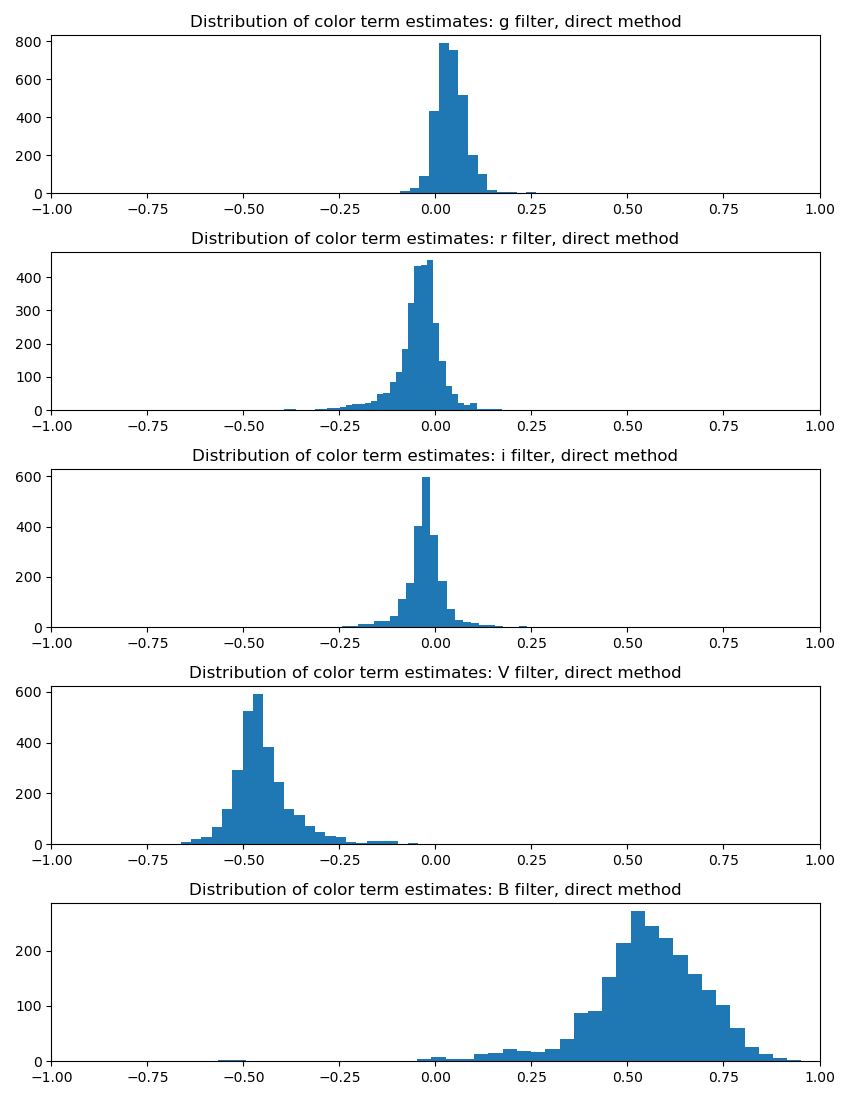

In [36]:
fig, axs = plt.subplots(len(filters))
fig.set_size_inches(8.5,11)
for i in range(len(filters)):
    term = filters[i][2]
    axs[i].hist(np.array(color_terms[term])[np.logical_and(np.array(color_terms[term]) >= -1, np.array(color_terms[term]) <= 1)], bins=50)
    axs[i].set_title(f'Distribution of color term estimates: {term} filter, direct method')
    axs[i].set_xlim(-1,1)
fig.tight_layout()

In [36]:
np.mean(color_terms['g']) - 3*np.std(color_terms['g'])

-0.16373559760111225

In [38]:
g_lis_unadj = np.array(color_terms['g'])
g_lis_adj1 = g_lis_unadj[g_lis_unadj != min(g_lis_unadj)]
g_lis = g_lis_adj1[g_lis_adj1 != min(g_lis_adj1)]

g_uncs_unadj = np.array(color_term_errors['g'])
g_uncs_adj1 = g_uncs_unadj[g_lis_unadj != min(g_lis_unadj)]
g_uncs = g_uncs_adj1[g_lis_adj1 != min(g_lis_adj1)]


mean: 0.04137907974868657
std: 0.045312245285348544


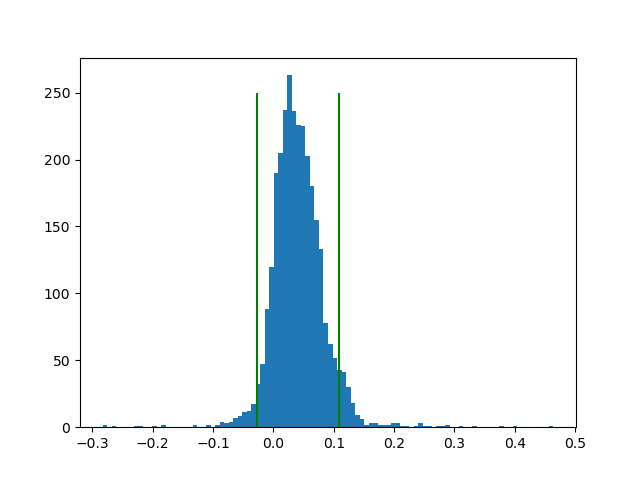

In [85]:
fig, ax = plt.subplots()
ax.hist(g_lis, bins=100)
ax.set_yscale('linear')
ax.vlines([np.mean(g_lis) - 1.5*np.std(g_lis), np.mean(g_lis) + 1.5*np.std(g_lis)],0, 250, color='green')
print(f'mean: {np.mean(g_lis)}')
print(f'std: {np.std(g_lis)}')

In [51]:
def weighted_avg(vals, uncs):
    weights = 1/np.power(uncs, 2)
    weighted = vals*weights
    est = np.sum(weighted)/np.sum(weights)
    est_unc = 1/np.sqrt(np.sum(weights))
    return est, est_unc

In [52]:
thresh_low = np.mean(g_lis) - 1.5*np.std(g_lis)
thresh_high = np.mean(g_lis) + 1.5*np.std(g_lis)

g_cuts = g_lis[np.logical_and(g_lis >= thresh_low, g_lis <= thresh_high)]
g_unc_cuts = g_uncs[np.logical_and(g_lis >= thresh_low, g_lis <= thresh_high)]

cg, cg_unc = weighted_avg(g_cuts, g_unc_cuts)

In [80]:
print(f'Cg = {cg:.5f} +/- {cg_unc:.5f}')

Cg = 0.03322 +/- 0.00024


In [122]:
# Sets up for the step-by-step thing below
i = 0
filter = 'g'
comp_filter = 'r'

all_points = dat[np.logical_and.reduce((dat[f'{filter}Good'] == True, dat[f'{comp_filter}Good'] == True, dat['Filter'] == filter))]
times = np.unique(all_points['Observation Time'])

1
6387.69406


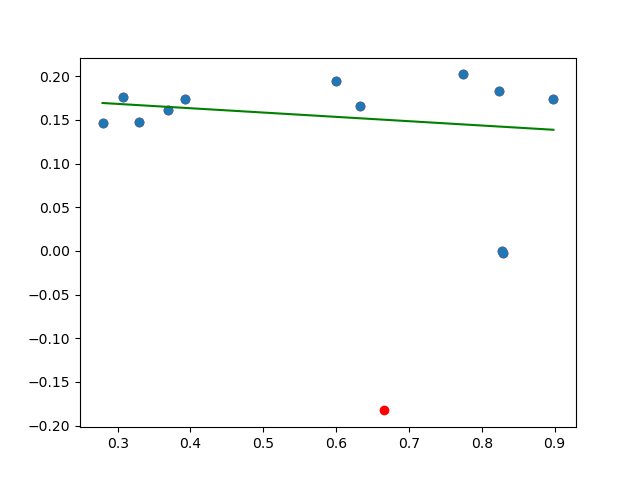

In [123]:
# Shows the filter plots one at a time, building block of the larger thing above
time = times[i]
i += 1
print(i)
points = all_points[all_points['Observation Time'] == time]
print(time)
if len(points) == 0:
    print('None')
else:
    fig, ax = plt.subplots()
    x = points[f'Pan {filter}Mag'] - points[f'Pan {comp_filter}Mag']
    y = points['Magnitude'] - points[f'Pan {filter}Mag']

    xerr = np.sqrt(points[f'Pan {filter}MagErr']**2 + points[f'Pan {comp_filter}MagErr']**2)
    yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {filter}MagErr'])

    ymask = np.ones_like(y, dtype=bool)
    ymask_adj = stdatest(y, ymask, 2.5)
    xa = x[ymask_adj]
    ya = y[ymask_adj]

    xerra = xerr[ymask_adj]
    yerra = yerr[ymask_adj]

    c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
    ax.scatter(x, y, label='flagged outliers', color='r')
    ax.scatter(xa, ya, label='accepted data')
    ax.plot([min(xa),max(xa)],[c*min(xa)+z,c*max(xa)+z],label='fit',color='g')


(array([ 80., 315., 431., 427., 361., 282., 195., 134., 110.,  85.,  68.,
         60.,  34.,  30.,  18.,  16.,  20.,  16.,   9.,   9.,   7.,   3.,
          4.,   6.,   6.,   1.,   1.,   2.,   4.,   0.,   1.,   1.,   2.,
          3.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   1.,   0.,   1.,   0.,   1.]),
 array([0.00258722, 0.00598931, 0.0093914 , 0.01279348, 0.01619557,
        0.01959766, 0.02299975, 0.02640184, 0.02980392, 0.03320601,
        0.0366081 , 0.04001019, 0.04341228, 0.04681436, 0.05021645,
        0.05361854, 0.05702063, 0.06042271, 0.0638248 , 0.06722689,
        0.07062898, 0.07403107, 0.07743315, 0.08083524, 0.08423733,
        0.08763942, 0.0910415 , 0.09444359, 0.09784568, 0.10124777,
        0.10464986, 0.10805194, 0.11145403, 0.11485612, 0.11825821,
        0.1216603 , 0.12506238, 0.12846447, 0.13186656, 0.13526865,
        0.13867073, 0.14207282, 0.14547491, 0.148877  , 0.15227909,
        0.15568117, 0.15908326, 0.16248535, 0.

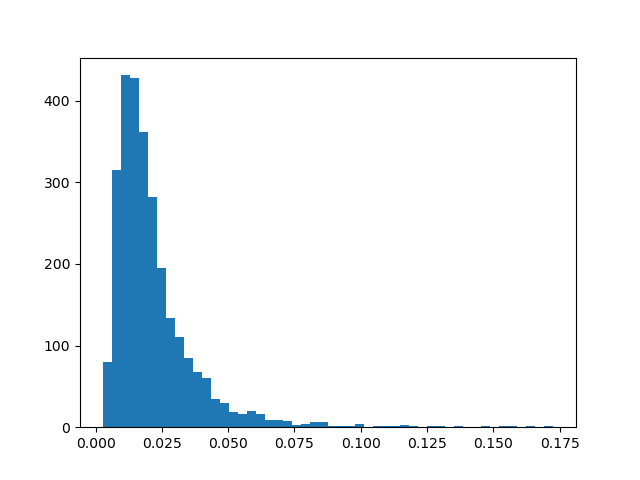

In [84]:
fig, ax = plt.subplots()
ax.hist(g_unc_cuts, bins=50)

finding Cg


  0%|          | 0/2998 [00:00<?, ?it/s]

finding Cr


  0%|          | 0/2908 [00:00<?, ?it/s]

finding Ci


  0%|          | 0/2168 [00:00<?, ?it/s]

finding CV


  0%|          | 0/2806 [00:00<?, ?it/s]

finding CB


  0%|          | 0/2160 [00:00<?, ?it/s]

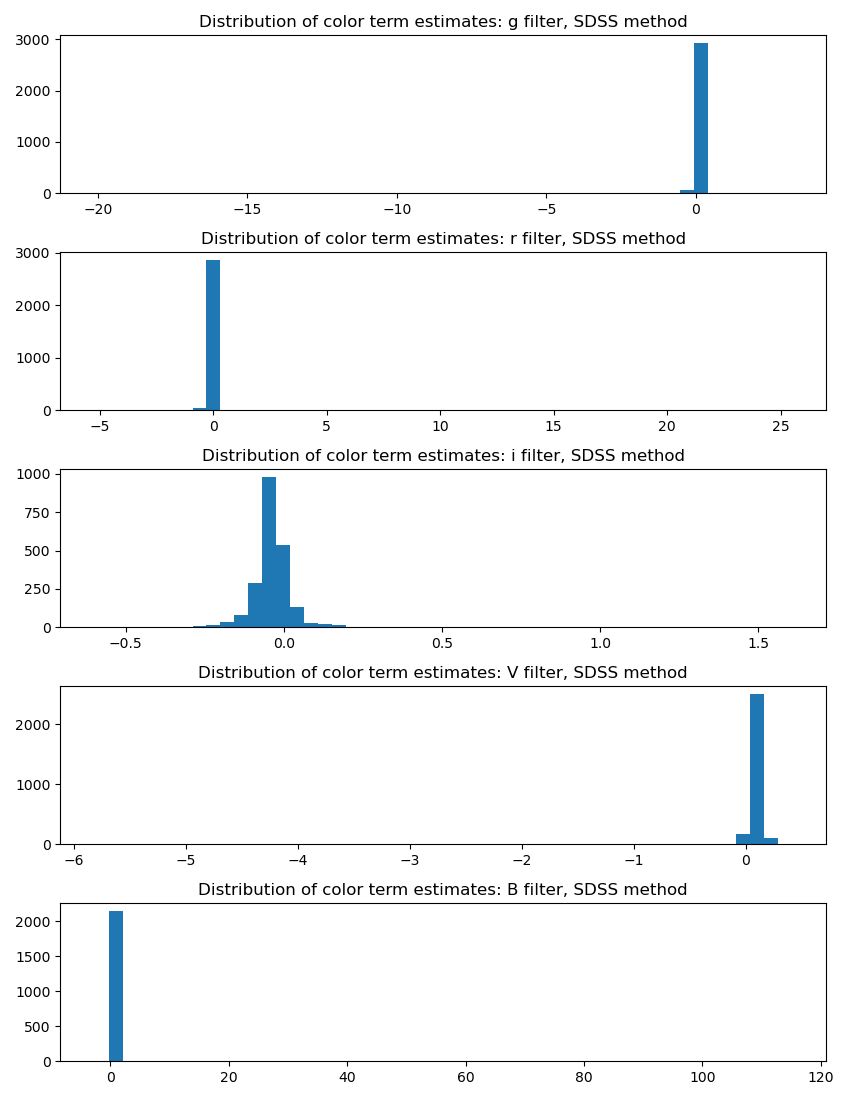

In [8]:
filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]

color_terms = {'g': [], 'r': [], 'i': []}
color_term_errors = {'g': [], 'r': [], 'i': []}

# Does the same thing as the verison above, but using some transformation formulas to estimate PanSTARRS B and V filters, but the estimates seem poor :(
# More specifically, these are for SDSS filters that do not match the PANSTARRS filters exactly
for lis in filters:
    term = lis[2]
    print(f'finding C{term}')
    cs = []
    zs = []
    c_uncs = []
    z_uncs = []
    all_points = dat[np.logical_and.reduce((dat[f'{lis[0]}Good'] == True, dat[f'{lis[1]}Good'] == True, dat[f'{lis[3]}Good'] == True, dat['Filter'] == lis[2]))]
    times = np.unique(all_points['Observation Time'])
    if term not in 'BV':
        for time in tqdm(times):
            points = all_points[all_points['Observation Time'] == time]
            x = points[f'Pan {lis[0]}Mag'] - points[f'Pan {lis[1]}Mag']
            y = points['Magnitude'] - points[f'Pan {lis[3]}Mag']
            xerr = np.sqrt(points[f'Pan {lis[0]}MagErr']**2 + points[f'Pan {lis[1]}MagErr']**2)
            yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {lis[3]}MagErr'])
            ymask = np.ones_like(y, dtype=bool)
            ymask_adj = stdatest(y, ymask, 2.5)
            xa = x[ymask_adj]
            ya = y[ymask_adj]
            xerra = xerr[ymask_adj]
            yerra = yerr[ymask_adj]
            c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
            cs += [c]
            zs += [z]
            c_uncs += [c_unc]
            z_uncs += [z_unc]
        color_terms[term] = cs
        color_term_errors[term] = c_uncs
    elif term == 'B':
        for time in tqdm(times):
            points = all_points[all_points['Observation Time'] == time]
            x = points[f'Pan {lis[0]}Mag'] - points[f'Pan {lis[1]}Mag']
            Bcorr = points[f'Pan gMag'] + 0.3130*x + 0.2271
            y = points['Magnitude'] - Bcorr
            xerr = np.sqrt(points[f'Pan {lis[0]}MagErr']**2 + points[f'Pan {lis[1]}MagErr']**2)
            yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {lis[3]}MagErr']) # This isn't actually right
            ymask = np.ones_like(y, dtype=bool)
            ymask_adj = stdatest(y, ymask, 2.5)
            xa = x[ymask_adj]
            ya = y[ymask_adj]
            xerra = xerr[ymask_adj]
            yerra = yerr[ymask_adj]
            c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
            cs += [c]
            zs += [z]
            c_uncs += [c_unc]
            z_uncs += [z_unc]
        color_terms[term] = cs
        color_term_errors[term] = c_uncs
    elif term == 'V':
        for time in tqdm(times):
            points = all_points[all_points['Observation Time'] == time]
            x = points[f'Pan {lis[0]}Mag'] - points[f'Pan {lis[1]}Mag']
            Vcorr = points[f'Pan gMag'] - 0.5784*x - 0.0038
            y = points['Magnitude'] - Vcorr
            xerr = np.sqrt(points[f'Pan {lis[0]}MagErr']**2 + points[f'Pan {lis[1]}MagErr']**2)
            yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {lis[3]}MagErr']) # This isn't actually right
            ymask = np.ones_like(y, dtype=bool)
            ymask_adj = stdatest(y, ymask, 2.5)
            xa = x[ymask_adj]
            ya = y[ymask_adj]
            xerra = xerr[ymask_adj]
            yerra = yerr[ymask_adj]
            c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
            cs += [c]
            zs += [z]
            c_uncs += [c_unc]
            z_uncs += [z_unc]
        color_terms[term] = cs
        color_term_errors[term] = c_uncs
  
fig, axs = plt.subplots(len(filters))
fig.set_size_inches(8.5,11)
for i in range(len(filters)):
    term = filters[i][2]
    axs[i].hist(color_terms[term], bins=50)
    axs[i].set_title(f'Distribution of color term estimates: {term} filter, SDSS method')
fig.tight_layout()

In [21]:
np.mean(color_term_errors['V']), np.mean(term_error_lists['V'])

(0.033033877177478396, 0.0409902608585297)

CB = 0.2472 +/- 0.0006
CV = 0.0836 +/- 0.0003


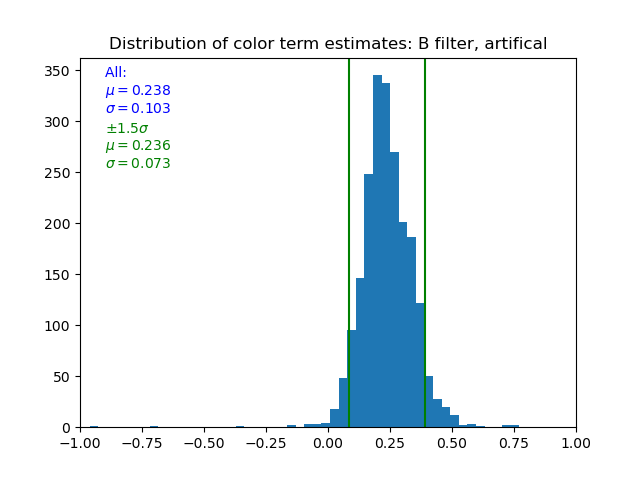

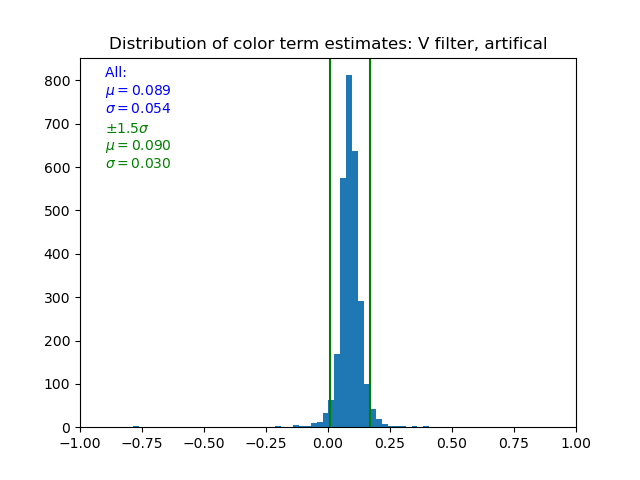

In [12]:
B_lis = np.array(color_terms['B'])
B_lis_uncs = np.array(color_term_errors['B'])
rest = B_lis[np.logical_and(B_lis >= -1, B_lis <= 1)]
rest_uncs = B_lis_uncs[np.logical_and(B_lis >= -1, B_lis <= 1)]

thresh_low = np.mean(rest) - 1.5*np.std(rest)
thresh_high = np.mean(rest) + 1.5*np.std(rest)

cuts = rest[np.logical_and(rest >= thresh_low, rest <= thresh_high)]
unc_cuts = rest_uncs[np.logical_and(rest >= thresh_low, rest <= thresh_high)]

cB, cB_unc = weighted_avg(cuts, unc_cuts)
print(f'CB = {cB:.4f} +/- {cB_unc:.4f}')
fig, ax = plt.subplots()
ax.set_title(f'Distribution of color term estimates: B filter, artifical')
ax.text(0.05, 0.85, f'All: \n$\mu={np.mean(rest):.3f}$ \n$\sigma = {np.std(rest):.3f}$', transform=ax.transAxes, c='b')
ax.axvline(thresh_low, c='g', label='$\pm 2\sigma')
ax.axvline(thresh_high, c='g')
ax.text(0.05, 0.7, f'$\pm 1.5\sigma$ \n$\mu={np.mean(cuts):.3f}$ \n$\sigma = {np.std(cuts):.3f}$', transform=ax.transAxes, c='g')
ax.hist(rest, bins=50)
ax.set_xbound(-1,1)

V_lis = np.array(color_terms['V'])
V_lis_uncs = np.array(color_term_errors['V'])
rest = V_lis[np.logical_and(V_lis >= -1, V_lis <= 1)]
rest_uncs = V_lis_uncs[np.logical_and(V_lis >= -1, V_lis <= 1)]

thresh_low = np.mean(rest) - 1.5*np.std(rest)
thresh_high = np.mean(rest) + 1.5*np.std(rest)

cuts = rest[np.logical_and(rest >= thresh_low, rest <= thresh_high)]
unc_cuts = rest_uncs[np.logical_and(rest >= thresh_low, rest <= thresh_high)]

cV, cV_unc = weighted_avg(cuts, unc_cuts)
print(f'CV = {cV:.4f} +/- {cV_unc:.4f}')
fig, ax = plt.subplots()
ax.set_title(f'Distribution of color term estimates: V filter, artifical')
ax.text(0.05, 0.85, f'All: \n$\mu={np.mean(rest):.3f}$ \n$\sigma = {np.std(rest):.3f}$', transform=ax.transAxes, c='b')
ax.axvline(thresh_low, c='g', label='$\pm 2\sigma')
ax.axvline(thresh_high, c='g')
ax.text(0.05, 0.7, f'$\pm 1.5\sigma$ \n$\mu={np.mean(cuts):.3f}$ \n$\sigma = {np.std(cuts):.3f}$', transform=ax.transAxes, c='g')
ax.hist(rest, bins=50)
ax.set_xbound(-1,1)


### Integrated

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.odr import *

%matplotlib widget

import requests
from astropy.table import Table
from astropy.io import ascii
from astropy.coordinates import SkyCoord

def get_panstarrs_matches_unc(field_stars, radius):
    '''
    WIP

    radius in arcseconds
    '''
    radius = radius/3600.

    columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
        gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,
        gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr""".split(',')
    columns = [x.strip() for x in columns]
    columns = [x for x in columns if x and not x.startswith('#')]
    results = []
    constraints = {'nDetections.gt':1}
    for i in tqdm(range(len(field_stars))):
        results += [ps1cone(field_stars[i]['Ra'],field_stars[i]['Dec'],radius,release='dr2',columns=columns,**constraints)]
    out = clean_results(results)
    return out

def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)

def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = f"{baseurl}/{release}/{table}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text

def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = f"{baseurl}/{release}/{table}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab

def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))
    
def clean_results(results):
    out = []
    for i in range(len(results)):
        if len(results[i]) > 0:
            tab = ascii.read(results[i])
            # improve the format
            for filter in 'grizy':
                col = filter+'MeanPSFMag'
                try:
                    tab[col].format = ".4f"
                    tab[col][tab[col] == -999.0] = np.nan
                except KeyError:
                    print("{} not found".format(col))
        else:
            tab = []
        out += [tab]
    out_filtered = out
    for i in range(len(out)):
        inds = []
        if out[i] != []:
            outarr = out[i].to_pandas().to_numpy()
            for j in range(len(outarr)):
                if np.any(np.isnan(outarr[j])) == False:
                    inds += [j]
            out_filtered[i] = outarr[inds]
    return out_filtered

In [2]:


def format_matches(fields_restricted, matches_prelim):
    add_cols = ['Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr']
    add_col_inds = [0, 9, 10, 11, 12, 13,
        14, 15, 16, 17, 18]

    print('Processing unique star matches')
    for i in tqdm(range(len(fields_restricted))):
        if len(matches_prelim[i]) == 1: # If the match is 1-1 just set the relevant values
            for colname, ind in zip(add_cols, add_col_inds):
                fields_restricted[i][colname] = matches_prelim[i][0][ind]
            fields_restricted[i]['Matched'] = True
        elif len(matches_prelim[i]) > 1: # If there are multiple candidates choose the closest one
            observed = SkyCoord(ra = fields_restricted[i]['Ra'], dec = fields_restricted[i]['Dec'], unit='degree')
            separations = [np.inf]
            min_ind = 0
            for option_ind, option in enumerate(matches_prelim[i]): # Go through each option and compare separations
                opt = SkyCoord(ra = option[1], dec = option[2], unit='degree')
                sep = observed.separation(opt)
                if sep < min(separations):
                    min_ind = option_ind
                separations += [sep]
            choose = matches_prelim[i][min_ind] # Do the same assignment off the closest option
            for colname, ind in zip(add_cols, add_col_inds):
                fields_restricted[i][colname] = choose[ind]
            fields_restricted[i]['Matched'] = True
    return fields_restricted

def format_matches_obs(field_obs_restricted, fields_restricted):
    add_cols = ['Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr', 'Matched']

    print('Processing observation matches')
    for obs_ind in tqdm(range(len(field_obs_restricted))): # Add matched field columns to the field observation data
        name = field_obs_restricted[obs_ind]['Name']
        field_data = fields_restricted[fields_restricted['Name'] == name][0]
        for colname in add_cols:
            field_obs_restricted[obs_ind][colname] = field_data[colname]
    return field_obs_restricted

def check_data(field_obs_full):
    print('Checking data')
    dat = np.lib.recfunctions.append_fields(field_obs_full,['gGood','rGood','iGood','zGood','yGood'],[[False]*len(field_obs_full)]*5, dtypes=[bool]*5,usemask=False)[field_obs_full['Matched'] == True]
    for filter in 'grizy':
        for ind, row in enumerate(dat):
            if row[f'Pan {filter}MagErr'] >= 0 and row[f'Pan {filter}MagErr'] <= row[f'Pan {filter}Mag']:
                dat[ind][f'{filter}Good'] = True
    return dat

def odr_lin(p,x):
    return p[0]*x+p[1]

def fit_color_term_errors(x,y,dx,dy):
    linear = Model(odr_lin)
    mydata = RealData(x, y, dx, dy)
    myodr = ODR(mydata, linear, beta0=[1, 1])
    myoutput = myodr.run()
    c = myoutput.beta[0]
    z = myoutput.beta[1]
    c_unc = myoutput.sd_beta[0]
    z_unc = myoutput.sd_beta[1]
    return c, z, c_unc, z_unc

def grubbs_test(y, ymask):
    ycurr = y[ymask]
    n = len(ycurr)
    a =  0.05
    p = a/(2*n)
    t = stats.t.ppf(1-p, n-2)

    G_crit = (n-1)/(np.sqrt(n))*np.sqrt(t**2/(n-2+t**2))
    G_ob = np.max(np.abs(ycurr - np.mean(ycurr)))/np.std(ycurr)
    if G_ob > G_crit:
        ymask[np.abs(y - np.mean(y)) >= np.max(np.abs(ycurr - np.mean(ycurr)))] = False
        ymask = grubbs_test(y, ymask)
    return ymask

def stdatest(y, ymask, a):
    ycurr = y[ymask]
    thresh = a*np.std(ycurr)

    if np.any(np.abs(ycurr - np.mean(ycurr)) > thresh):
        ymask[np.abs(y - np.mean(ycurr)) > thresh] = False
        stdatest(y, ymask, a)
    return ymask

def weighted_avg(vals, uncs):
    weights = 1/np.power(uncs, 2)
    weighted = vals*weights
    est = np.sum(weighted)/np.sum(weights)
    est_unc = 1/np.sqrt(np.sum(weights))
    return est, est_unc

In [3]:
# Integrated process with tunable parameters for all steps:

def retrieve_data():
    fields_init = np.load('../fields.npy') # Load the list of unique field stars in the dataset
    field_obs_init = np.load('../field_obs.npy') # Load the list of field star observations

    field_catalog_spec = np.dtype({'names': [
        'Matched', 'Nova name', 'Name', 'Ra', 'Dec',
        'Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr'
        ], 'formats': [
        bool,'U32', 'U32', float, float,
        float, float, float, float, float, float,
        float, float, float, float, float
        ]})

    observation_catalog_spec = np.dtype({'names': [
        'Matched', 'Nova name', 'Name', 'Ra', 'Dec', 'Observation Time', 'Filter', 'Magnitude', 'Magnitude error',
        'Pan ID', 'Pan gMag', 'Pan rMag','Pan iMag','Pan zMag','Pan yMag',
        'Pan gMagErr', 'Pan rMagErr','Pan iMagErr','Pan zMagErr','Pan yMagErr'
        ], 'formats': [
        bool,'U32','U32',float,float,float,'U1',float,float,
        float, float, float, float, float, float,
        float, float, float, float, float
        ]})
    
    fields = np.empty(len(fields_init),dtype=field_catalog_spec)# Reformat the field list
    for col in fields_init.dtype.names:
        fields[col] = fields_init[col] # Fill in the observation column, the remaining columns are for match (PanSTARRS) data
    fields['Matched'] = False # Matched flag default to False until matches loaded

    field_obs = np.empty(len(field_obs_init),dtype=observation_catalog_spec) # Reformat the field observation list
    for col in field_obs_init.dtype.names:
        field_obs[col] = field_obs_init[col] # Fill in the observation column, the remaining columns are for match (PanSTARRS) data
    field_obs['Matched'] = False # Matched flag default to False until matches loaded

    fields_restricted = fields[fields['Dec'] > -30] # Cut data to match PanSTARRS area
    field_obs_restricted = field_obs[field_obs['Dec'] > -30]

    processed_cache = Path('cache/processed_matches.npy')
    if processed_cache.is_file(): #Skip the whole processing step (just pushing around arrays) if it has already been done
        print('Cache includes processed matches, delete this file if processing procedure has changed')
        dat = np.load('cache/processed_matches.npy')
    else:
        match_cache = Path("cache/pan_matches.npy")
        if match_cache.is_file(): # Load match data if it already exists
            print('Loading cached matches.')
            matches_prelim = np.load('cache/pan_matches.npy', allow_pickle=True)
            fields_full = format_matches(fields_restricted, matches_prelim)
            field_obs_full = format_matches_obs(field_obs_restricted, fields_full)
            dat = check_data(field_obs_full) # Add masks for each filter
        else: # Otherwise find new matches
            print('Requesting new matches')
            matches_prelim = get_panstarrs_matches_unc(fields_restricted, 2)
            fields_full = format_matches(fields_restricted, matches_prelim)
            field_obs_full = format_matches_obs(field_obs_restricted, fields_full)
            np.save('cache/pan_matches.npy',matches_prelim)
            dat = check_data(field_obs_full)
        np.save('cache/processed_matches.npy', dat)
    return dat

def fit_color_terms(dat, scatter_sigma):
    filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]

    color_terms = {}
    color_term_errors = {}

    
    sigmas = {}
    for ind, lis in enumerate(filters):
        term = lis[2]
        if isinstance(scatter_sigma, list):
            sigmas[term] = scatter_sigma[ind]
        else:
            sigmas[term] = scatter_sigma

    # For each of the filters, perform a regression on the color term plot for each exposure, saves a list of color term estimates and uncertainties
    for lis in filters:
        term = lis[2]
        print(f'finding C{term}')
        cs = []
        zs = []
        c_uncs = []
        z_uncs = []
        all_points = dat[np.logical_and.reduce((dat[f'{lis[0]}Good'] == True, dat[f'{lis[1]}Good'] == True, dat[f'{lis[3]}Good'] == True, dat['Filter'] == lis[2]))]
        times = np.unique(all_points['Observation Time'])
        total_observations = len(all_points)
        rejected_observations = []
        for time in tqdm(times):
            points = all_points[all_points['Observation Time'] == time]
            x = points[f'Pan {lis[0]}Mag'] - points[f'Pan {lis[1]}Mag']
            y = points['Magnitude'] - points[f'Pan {lis[3]}Mag']
            xerr = np.sqrt(points[f'Pan {lis[0]}MagErr']**2 + points[f'Pan {lis[1]}MagErr']**2)
            yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {lis[3]}MagErr'])
            ymask = np.ones_like(y, dtype=bool)
            ymask_adj = stdatest(y, ymask, sigmas[term])
            xa = x[ymask_adj]
            ya = y[ymask_adj]
            xerra = xerr[ymask_adj]
            yerra = yerr[ymask_adj]
            c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
            cs += [c]
            zs += [z]
            c_uncs += [c_unc]
            z_uncs += [z_unc]
            rejected_observations += [np.count_nonzero(np.logical_not(ymask_adj))]
        color_terms[term] = cs
        color_term_errors[term] = c_uncs
        print(f'Rejected {len(rejected_observations)} of {total_observations} observations ({len(rejected_observations)/total_observations*100:.2f}%).')
        print(f'The average exposure contained {np.mean(rejected_observations):.2f} rejects and the most in a single exposure was {max(rejected_observations)}.')
    return color_terms, color_term_errors

def derive_color_terms(color_terms, color_term_errors, hist_sigmas):
    filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]
    c = {}
    c_unc = {}
    c2 = {}
    c_unc2 = {}
    sigmas = {}

    for ind, lis in enumerate(filters):
        term = lis[2]
        if isinstance(hist_sigmas, list):
            sigmas[term] = hist_sigmas[ind]
        else:
            sigmas[term] = hist_sigmas
    # fig, axs = plt.subplots(len(filters))
    # fig.set_size_inches(8.5,11)
    for i in range(len(filters)):
        # Without initial cut
        '''
        fig, ax = plt.subplots()
        term = filters[i][2]
        working = np.array(color_terms[term])
        working_uncs = np.array(color_term_errors[term])

        thresh_low = np.mean(working) - histogram_sigma*np.std(working)
        thresh_high = np.mean(working) + histogram_sigma*np.std(working)

        c_cuts = working[np.logical_and(working >= thresh_low, working <= thresh_high)]
        c_unc_cuts = working_uncs[np.logical_and(working >= thresh_low, working <= thresh_high)]

        c[term], c_unc[term] = weighted_avg(c_cuts, c_unc_cuts)

        ax.hist(working, bins=50)
        ax.set_title(f'Distribution of color term estimates: {term} filter, direct method, all')
        ax.text(0.05, 0.9, f'$\mu={np.mean(working):.3f}$ \n$\sigma = {np.std(working):.3f}$', transform=ax.transAxes, c='b')
        ax.axvline(thresh_low, c='g', label='$\pm 2\sigma')
        ax.axvline(thresh_high, c='g')
        ax.text(0.05, 0.8, f'$\mu={np.mean(c_cuts):.3f}$ \n$\sigma = {np.std(c_cuts):.3f}$', transform=ax.transAxes, c='g')
        '''
        # With initial cut
        fig, ax = plt.subplots()
        term = filters[i][2]
        histogram_sigma = sigmas[term]
        working = np.array(color_terms[term])
        working2 = working[np.logical_and(working >= -1, working <= 1)]
        working_uncs = np.array(color_term_errors[term])
        working_uncs2 = working_uncs[np.logical_and(working >= -1, working <= 1)]

        thresh_low2 = np.mean(working2) - histogram_sigma*np.std(working2)
        thresh_high2 = np.mean(working2) + histogram_sigma*np.std(working2)

        c_cuts2 = working2[np.logical_and(working2 >= thresh_low2, working2 <= thresh_high2)]
        c_unc_cuts2 = working_uncs2[np.logical_and(working2 >= thresh_low2, working2 <= thresh_high2)]

        c2[term], c_unc2[term] = weighted_avg(c_cuts2, c_unc_cuts2)

        ax.hist(working2, bins=50)
        # ax.set_title(f'Distribution of color term estimates: {term} filter, direct method, restricted')
        ax.set_title(f'Distribution of color term estimates: {term} filter')
        ax.text(0.05, 0.85, f'All: \n$\mu={np.mean(working2):.3f}$ \n$\sigma = {np.std(working2):.3f}$', transform=ax.transAxes, c='b')
        ax.axvline(thresh_low2, c='g', label='$\pm 2\sigma')
        ax.axvline(thresh_high2, c='g')
        ax.text(0.05, 0.7, f'$\pm 1.5\sigma$ \n$\mu={np.mean(c_cuts2):.3f}$ \n$\sigma = {np.std(c_cuts2):.3f}$', transform=ax.transAxes, c='g')
        ax.set_xlim(-1, 1)

    for i in range(len(filters)):
        term = filters[i][2]
        # print(f'C{term} = {c[term]:.4f} +/- {c_unc[term]:.4f}')
        print(f'C{term} = {c2[term]:.4f} +/- {c_unc2[term]:.4f}')
    return c, c_unc




In [4]:
# Step 1
dat = retrieve_data()

Cache includes processed matches, delete this file if processing procedure has changed


In [5]:
# Step 2
term_lists, term_error_lists = fit_color_terms(dat, 2.5)

finding Cg


  0%|          | 0/2998 [00:00<?, ?it/s]

Rejected 2998 of 112651 observations (2.66%).
The average exposure contained 2.30 rejects and the most in a single exposure was 37.
finding Cr


  0%|          | 0/2908 [00:00<?, ?it/s]

Rejected 2908 of 103869 observations (2.80%).
The average exposure contained 2.20 rejects and the most in a single exposure was 28.
finding Ci


  0%|          | 0/2168 [00:00<?, ?it/s]

Rejected 2168 of 79999 observations (2.71%).
The average exposure contained 2.30 rejects and the most in a single exposure was 29.
finding CV


  0%|          | 0/2806 [00:00<?, ?it/s]

Rejected 2806 of 100744 observations (2.79%).
The average exposure contained 2.80 rejects and the most in a single exposure was 34.
finding CB


  0%|          | 0/2160 [00:00<?, ?it/s]

Rejected 2160 of 77659 observations (2.78%).
The average exposure contained 1.88 rejects and the most in a single exposure was 27.


In [6]:
plt.close('all')

Cg = 0.0501 +/- 0.0003
Cr = -0.0443 +/- 0.0004
Ci = -0.0376 +/- 0.0005
CV = -0.4771 +/- 0.0004
CB = 0.5646 +/- 0.0007


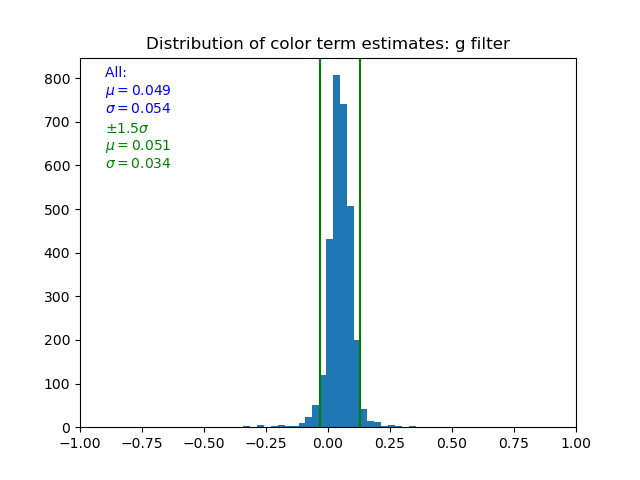

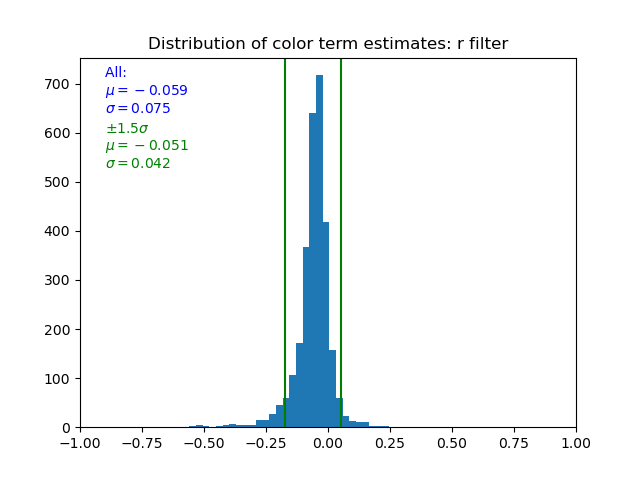

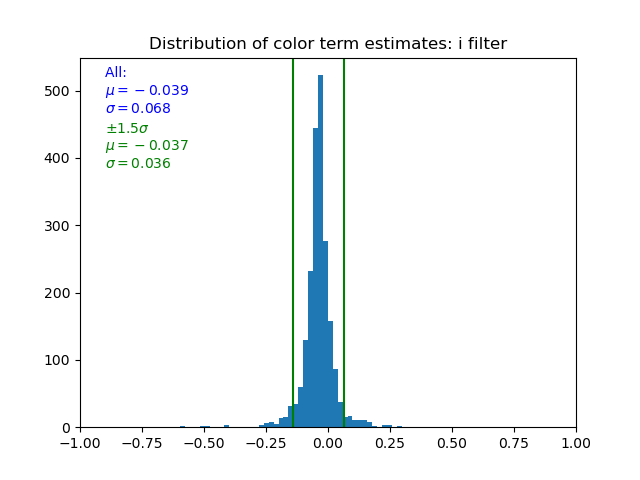

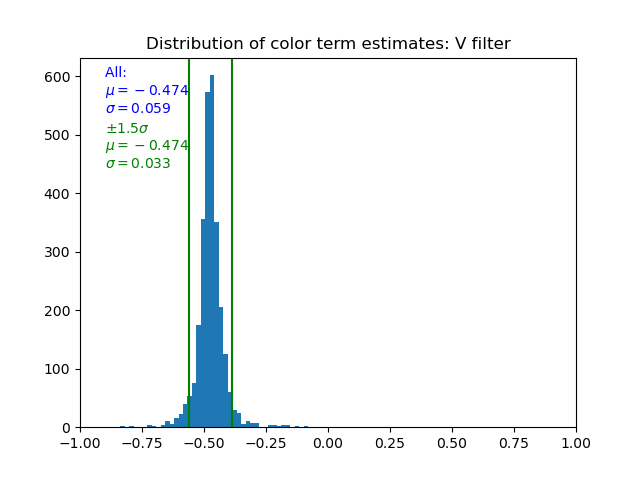

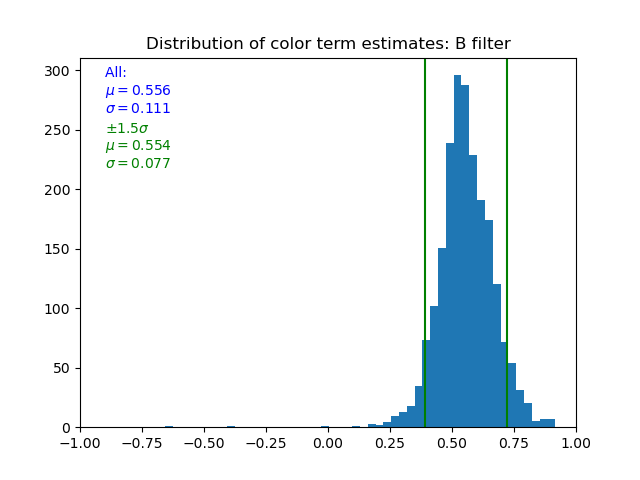

In [7]:
# Step 3
terms, errors = derive_color_terms(term_lists, term_error_lists, 1.5)

In [238]:
plt.close('all')

In [239]:
# Step by step with revised methods
filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]

i = 0
filter = filters[4]

all_points = dat[np.logical_and.reduce((dat[f'{filter[0]}Good'] == True, dat[f'{filter[1]}Good'] == True, dat[f'{filter[3]}Good'] == True, dat['Filter'] == filter[2]))]
times = np.unique(all_points['Observation Time'])

1
6389.84766


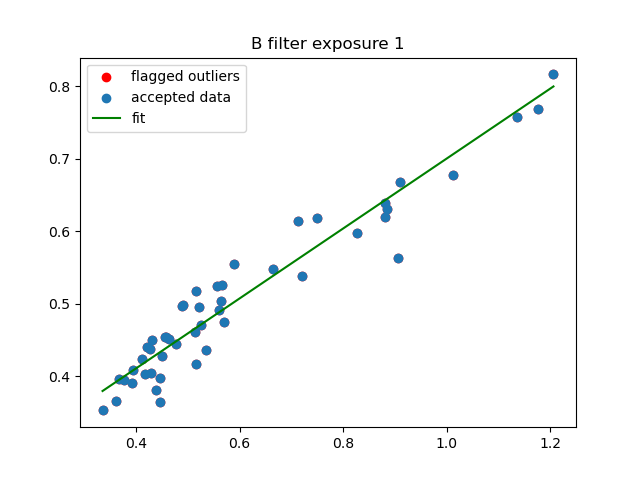

In [240]:
time = times[i]
i += 1
print(i)
points = all_points[all_points['Observation Time'] == time]
print(time)
if len(points) == 0:
    print('None')
else:
    fig, ax = plt.subplots()
    ax.set_title(f'{filter[2]} filter exposure {i}')
    x = points[f'Pan {filter[0]}Mag'] - points[f'Pan {filter[1]}Mag']
    y = points['Magnitude'] - points[f'Pan {filter[3]}Mag']

    xerr = np.sqrt(points[f'Pan {filter[0]}MagErr']**2 + points[f'Pan {filter[1]}MagErr']**2)
    yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {filter[3]}MagErr'])

    ymask = np.ones_like(y, dtype=bool)
    ymask_adj = stdatest(y, ymask, 5)
    xa = x[ymask_adj]
    ya = y[ymask_adj]

    xerra = xerr[ymask_adj]
    yerra = yerr[ymask_adj]

    c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
    ax.scatter(x, y, label='flagged outliers', color='r')
    ax.scatter(xa, ya, label='accepted data')
    ax.plot([min(xa),max(xa)],[c*min(xa)+z,c*max(xa)+z],label='fit',color='g')
    ax.legend()


### Comparison

In [283]:
plt.close('all')

In [284]:
# Step by step with revised methods
filters = [('g', 'r', 'g', 'g'), ('r', 'i', 'r', 'r'), ('r', 'i', 'i', 'i'), ('g', 'r', 'V', 'g'), ('g', 'r', 'B', 'g')]

i = 0
# filter = filters[4]
filter = filters[3]

all_points = dat[np.logical_and.reduce((dat[f'{filter[0]}Good'] == True, dat[f'{filter[1]}Good'] == True, dat[f'{filter[3]}Good'] == True, dat['Filter'] == filter[2]))]
times = np.unique(all_points['Observation Time'])

3
6388.69176


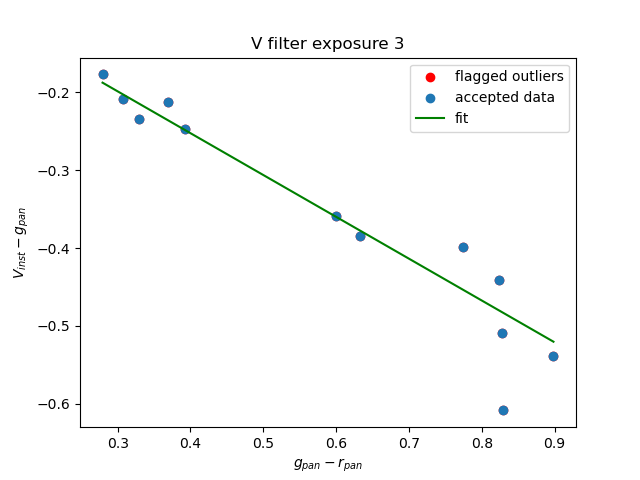

In [290]:
time = times[i]
i += 1
print(i)
points = all_points[all_points['Observation Time'] == time]
print(time)
if len(points) == 0:
    print('None')
else:
    fig, ax = plt.subplots()
    ax.set_title(f'{filter[2]} filter exposure {i}')
    x = points[f'Pan {filter[0]}Mag'] - points[f'Pan {filter[1]}Mag']
    y = points['Magnitude'] - points[f'Pan {filter[3]}Mag']

    xerr = np.sqrt(points[f'Pan {filter[0]}MagErr']**2 + points[f'Pan {filter[1]}MagErr']**2)
    yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {filter[3]}MagErr'])

    ymask = np.ones_like(y, dtype=bool)
    ymask_adj = stdatest(y, ymask, 2)
    xa = x[ymask_adj]
    ya = y[ymask_adj]

    xerra = xerr[ymask_adj]
    yerra = yerr[ymask_adj]

    c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
    ax.scatter(x, y, label='flagged outliers', color='r')
    ax.scatter(xa, ya, label='accepted data')
    ax.plot([min(xa),max(xa)],[c*min(xa)+z,c*max(xa)+z],label='fit',color='g')
    ax.set_xlabel('$g_{{pan}} - r_{{pan}}$')
    # ax.set_ylabel('$B_{{inst}} - g_{{pan}}$')
    ax.set_ylabel('$V_{{inst}} - g_{{pan}}$')
    ax.legend()


In [286]:
j = 0
filter = ('g', 'r', 'V', 'g')
# filter = ('g', 'r', 'B', 'g')

all_points = dat[np.logical_and.reduce((dat[f'{filter[0]}Good'] == True, dat[f'{filter[1]}Good'] == True, dat[f'{filter[3]}Good'] == True, dat['Filter'] == filter[2]))]
times = np.unique(all_points['Observation Time'])

3
6388.69176


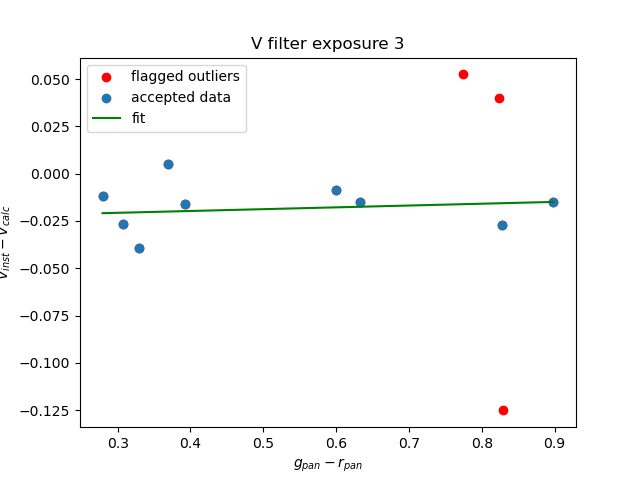

In [291]:
time = times[j]
j += 1
print(j)
points = all_points[all_points['Observation Time'] == time]
print(time)
if len(points) == 0:
    print('None')
else:
    fig, ax = plt.subplots()
    ax.set_title(f'{filter[2]} filter exposure {j}')
    x = points[f'Pan {filter[0]}Mag'] - points[f'Pan {filter[1]}Mag']
    Vcorr = points[f'Pan gMag'] - 0.5784*x - 0.0038
    # Bcorr = points[f'Pan gMag'] + 0.3130*x + 0.2271
    y = points['Magnitude'] - Vcorr
    # y = points['Magnitude'] - Bcorr

    xerr = np.sqrt(points[f'Pan {filter[0]}MagErr']**2 + points[f'Pan {filter[1]}MagErr']**2)
    yerr = np.sqrt(points['Magnitude error']**2 + points[f'Pan {filter[3]}MagErr'])

    ymask = np.ones_like(y, dtype=bool)
    ymask_adj = stdatest(y, ymask, 2)
    xa = x[ymask_adj]
    ya = y[ymask_adj]

    xerra = xerr[ymask_adj]
    yerra = yerr[ymask_adj]

    c, z, c_unc, z_unc = fit_color_term_errors(xa, ya, xerra, yerra)
    ax.scatter(x, y, label='flagged outliers', color='r')
    ax.scatter(xa, ya, label='accepted data')
    ax.plot([min(xa),max(xa)],[c*min(xa)+z,c*max(xa)+z],label='fit',color='g')
    ax.set_xlabel('$g_{{pan}} - r_{{pan}}$')
    # ax.set_ylabel('$B_{{inst}} - B_{{calc}}$')
    ax.set_ylabel('$V_{{inst}} - V_{{calc}}$')
    ax.legend()